## this is the version i do not engineer the features of x
## no self loops included

In [51]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv, NNConv, global_mean_pool, TopKPooling
from torch_geometric.nn.glob import GlobalAttention
from torch_geometric.data import Data,DataLoader
# from torch.utils.data import DataLoader, TensorDataset
# from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch_geometric.utils.convert import from_scipy_sparse_matrix
from torch_geometric.utils.convert import from_networkx
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat, savemat
import pandas as pd
import scipy.special as SS
import scipy.stats as SSA
import copy
import math
from sklearn.model_selection import ParameterGrid
import os
import numpy.linalg as LA
import gzip
from torch_geometric.utils import add_self_loops

from scipy import sparse

# load pickle module
import pickle
import networkx as nx
import torch.nn as nn

from tqdm import tqdm 

In [100]:
R0 = 2.5
rs = np.array([20, 10, 2.0, 1.0, 0.5, 0.2, 0.1, 0.05, 0.025, 5.   ,  2.5  , 13.333,  3.333,  1.333,  0.667,  0.286,  0.133,
        0.067,  0.033, 0.37,7.4])

In [53]:
np.log(rs)

array([ 2.99573227,  2.30258509,  0.69314718,  0.        , -0.69314718,
       -1.60943791, -2.30258509, -2.99573227, -3.68887945,  1.60943791,
        0.91629073,  2.59024217,  1.2038728 ,  0.28743204, -0.40496523,
       -1.25176347, -2.01740615, -2.70306266, -3.41124772, -0.99425227,
        2.00148   ])

In [101]:
rs.sort()

In [102]:
WN = np.loadtxt('../W_avg.csv') ### numpy arrary

In [103]:
g_s = nx.from_numpy_array(WN)
edges = np.array(g_s.edges()).transpose()
edge_index = torch.tensor(edges,dtype = torch.int64)
# edge_weight = torch.tensor(WN[edge_index[0], edge_index[1]], dtype=torch.float)
edge_weights = []
for (u, v) in g_s.edges():
    edge_weights.append([g_s[u][v]['weight']])
edge_weights = torch.tensor(edge_weights, dtype=torch.float32)

In [104]:
def load_gzipped_numpy(filename):
    try:
        with gzip.open(filename, 'rb') as f:
            return np.load(f, allow_pickle=True)
    except FileNotFoundError:
        return [0]

In [105]:
r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
           5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
        0.067:3,  0.033:3, 0.37:2,7.4:0}

In [106]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/python_cutoff_addno/'
#### data preparation
dataset = []

for r_idx in range(21):
    r = rs[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:]
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

0.025 3
0.033 3
0.05 3
0.067 3
0.1 2
0.133 2
0.2 2
0.286 2
0.37 2
0.5 1
0.667 1
1.0 1
1.333 1
2.0 1
2.5 1
3.333 1
5.0 0
7.4 0
10.0 0
13.333 0
20.0 0


In [107]:
from torch.utils.data import random_split
all_data_len = len(dataset)
train_data, test_data = random_split(dataset, [int(all_data_len*0.8), int(all_data_len*0.2)])

In [108]:
class GCN(torch.nn.Module): ### the simpliest model that GNN and it is classical, used as baseline
    def __init__(self, num_node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 128)     
        self.conv2 = GCNConv(128, 64) 
        self.conv3 = GCNConv(64, 16) 
        self.conv4 = GCNConv(16, 8) 
        self.fc = torch.nn.Linear(8, 1)


    """
        hyperparameters:
        - number of hidden layers
        - number of hidden channels
        - dropout rate (now it's zero)
        - learning rate <- most important to tune
        - weight decay
        - etc etc.
    """

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch
#         edge_index, edge_weight = add_self_loops(edge_index, edge_attr=edge_weight, num_nodes=x.size(0))

        x = self.conv1(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = self.conv2(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = self.conv3(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)
        
        x = self.conv4(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
        x = F.elu(x)

        x = global_mean_pool(x, batch)
        x = self.fc(x)

        return x

# Now we can create a DataLoader
myloader = DataLoader(train_data, batch_size=128, shuffle=True)
# Create a model and an optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=50).to(device) ### only look at the last 30 
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

def train(model, optimizer, loader):
    model.train()
    loss_all = 0
    correct = 0
    y_true = []
    total = 0
    results = []
    for data in myloader:
        data = data.to(device)
        optimizer.zero_grad() 
        output = model(data) 
        label = data.y.to(device)
        y_true.append(label)
        
        # Calculate weights based on extremes
#         weights = calculate_weights(label, -2.8,2)
        # Use the custom weighted loss function
#         loss = weighted_mse_loss(output, label, weights)
        loss = F.mse_loss(output, label) 
#         loss = F.cross_entropy(output, label)
        loss.backward() 
        loss_all += data.num_graphs * loss.item()
        
        optimizer.step() 
        results.append(output)
    
    return loss_all / len(myloader.dataset), results, y_true



counter = 0
count_epochs = 0
best = float("inf")
epochs = 100
patience = 15
loss_ep= []
 
for epoch in (pbar := tqdm(range(1, epochs + 1))):
    loss, myres, reals = train(model, optimizer, myloader)
    loss_ep.append(loss)
#     ac_ep.append(ac)
    print('Epoch: {:03d}, Loss: {:.5f}'.format(epoch, loss))
    if loss < best:
        best = loss
        counter = 0
    else:
        counter += 1
        count_epochs += 1
        
    if counter > patience:
        break
        # print(f"Epoch: {​​​​​​epoch:03d}​​​​​​, Loss: {​​​​​​loss:.4f}​​​​​​")
#     scheduler.step()
    pbar.set_description(f"Epoch: {epoch:03d}, Loss: {loss:.4f}")
print("\n", "Stopped early at epoch: ", count_epochs)


/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
Epoch: 001, Loss: 5.1831:   1%|▏              | 1/100 [00:44<1:13:01, 44.26s/it]

Epoch: 001, Loss: 5.18312


Epoch: 002, Loss: 4.0236:   2%|▎              | 2/100 [01:28<1:12:11, 44.20s/it]

Epoch: 002, Loss: 4.02359


Epoch: 003, Loss: 4.5497:   3%|▍              | 3/100 [02:12<1:11:30, 44.23s/it]

Epoch: 003, Loss: 4.54970


Epoch: 004, Loss: 4.0172:   4%|▌              | 4/100 [02:57<1:10:50, 44.27s/it]

Epoch: 004, Loss: 4.01717


Epoch: 005, Loss: 4.0162:   5%|▊              | 5/100 [03:41<1:09:59, 44.20s/it]

Epoch: 005, Loss: 4.01619


Epoch: 006, Loss: 4.0199:   6%|▉              | 6/100 [04:25<1:09:14, 44.20s/it]

Epoch: 006, Loss: 4.01986


Epoch: 007, Loss: 4.0139:   7%|█              | 7/100 [05:09<1:08:33, 44.24s/it]

Epoch: 007, Loss: 4.01389


Epoch: 008, Loss: 4.0135:   8%|█▏             | 8/100 [05:53<1:07:40, 44.14s/it]

Epoch: 008, Loss: 4.01354


Epoch: 009, Loss: 4.0139:   9%|█▎             | 9/100 [06:37<1:06:58, 44.16s/it]

Epoch: 009, Loss: 4.01387


Epoch: 010, Loss: 4.0071:  10%|█▍            | 10/100 [07:21<1:06:14, 44.16s/it]

Epoch: 010, Loss: 4.00712


Epoch: 011, Loss: 4.0057:  11%|█▌            | 11/100 [08:05<1:05:27, 44.13s/it]

Epoch: 011, Loss: 4.00568


Epoch: 012, Loss: 4.0067:  12%|█▋            | 12/100 [08:50<1:04:45, 44.15s/it]

Epoch: 012, Loss: 4.00674


Epoch: 013, Loss: 4.0034:  13%|█▊            | 13/100 [09:34<1:03:57, 44.11s/it]

Epoch: 013, Loss: 4.00345


Epoch: 014, Loss: 4.0082:  14%|█▉            | 14/100 [10:18<1:03:16, 44.14s/it]

Epoch: 014, Loss: 4.00819


Epoch: 015, Loss: 4.0068:  15%|██            | 15/100 [11:02<1:02:31, 44.13s/it]

Epoch: 015, Loss: 4.00676


Epoch: 016, Loss: 3.9977:  16%|██▏           | 16/100 [11:46<1:01:44, 44.10s/it]

Epoch: 016, Loss: 3.99768


Epoch: 017, Loss: 3.9973:  17%|██▍           | 17/100 [12:30<1:01:07, 44.18s/it]

Epoch: 017, Loss: 3.99727


Epoch: 018, Loss: 3.9975:  18%|██▌           | 18/100 [13:15<1:00:24, 44.20s/it]

Epoch: 018, Loss: 3.99748


Epoch: 019, Loss: 3.9912:  19%|███             | 19/100 [13:59<59:39, 44.19s/it]

Epoch: 019, Loss: 3.99119


Epoch: 020, Loss: 3.9927:  20%|███▏            | 20/100 [14:43<58:54, 44.19s/it]

Epoch: 020, Loss: 3.99268


Epoch: 021, Loss: 3.9880:  21%|███▎            | 21/100 [15:27<58:12, 44.21s/it]

Epoch: 021, Loss: 3.98797


Epoch: 022, Loss: 3.9804:  22%|███▌            | 22/100 [16:11<57:23, 44.15s/it]

Epoch: 022, Loss: 3.98037


Epoch: 023, Loss: 3.9786:  23%|███▋            | 23/100 [16:55<56:36, 44.11s/it]

Epoch: 023, Loss: 3.97859


Epoch: 024, Loss: 3.9794:  24%|███▊            | 24/100 [17:39<55:53, 44.13s/it]

Epoch: 024, Loss: 3.97941


Epoch: 025, Loss: 3.9787:  25%|████            | 25/100 [18:24<55:07, 44.11s/it]

Epoch: 025, Loss: 3.97867


Epoch: 026, Loss: 3.9764:  26%|████▏           | 26/100 [19:08<54:29, 44.18s/it]

Epoch: 026, Loss: 3.97636


Epoch: 027, Loss: 3.9741:  27%|████▎           | 27/100 [19:52<53:47, 44.21s/it]

Epoch: 027, Loss: 3.97406


Epoch: 028, Loss: 3.9594:  28%|████▍           | 28/100 [20:36<53:05, 44.25s/it]

Epoch: 028, Loss: 3.95935


Epoch: 029, Loss: 3.9528:  29%|████▋           | 29/100 [21:21<52:22, 44.25s/it]

Epoch: 029, Loss: 3.95276


Epoch: 030, Loss: 3.9512:  30%|████▊           | 30/100 [22:05<51:38, 44.27s/it]

Epoch: 030, Loss: 3.95124


Epoch: 031, Loss: 3.9484:  31%|████▉           | 31/100 [22:49<50:53, 44.26s/it]

Epoch: 031, Loss: 3.94836


Epoch: 032, Loss: 3.9459:  32%|█████           | 32/100 [23:34<50:12, 44.30s/it]

Epoch: 032, Loss: 3.94588


Epoch: 033, Loss: 3.9420:  33%|█████▎          | 33/100 [24:18<49:24, 44.25s/it]

Epoch: 033, Loss: 3.94204


Epoch: 034, Loss: 3.9480:  34%|█████▍          | 34/100 [25:02<48:40, 44.25s/it]

Epoch: 034, Loss: 3.94804


Epoch: 035, Loss: 3.9214:  35%|█████▌          | 35/100 [25:46<47:55, 44.24s/it]

Epoch: 035, Loss: 3.92141


Epoch: 036, Loss: 3.9161:  36%|█████▊          | 36/100 [26:30<47:10, 44.23s/it]

Epoch: 036, Loss: 3.91606


Epoch: 037, Loss: 3.9175:  37%|█████▉          | 37/100 [27:15<46:24, 44.20s/it]

Epoch: 037, Loss: 3.91746


Epoch: 038, Loss: 3.9054:  38%|██████          | 38/100 [27:59<45:41, 44.22s/it]

Epoch: 038, Loss: 3.90539


Epoch: 039, Loss: 3.8929:  39%|██████▏         | 39/100 [28:43<44:59, 44.25s/it]

Epoch: 039, Loss: 3.89291


Epoch: 040, Loss: 3.8861:  40%|██████▍         | 40/100 [29:27<44:15, 44.26s/it]

Epoch: 040, Loss: 3.88607


Epoch: 041, Loss: 3.8925:  41%|██████▌         | 41/100 [30:12<43:37, 44.36s/it]

Epoch: 041, Loss: 3.89252


Epoch: 042, Loss: 3.8774:  42%|██████▋         | 42/100 [30:56<42:44, 44.22s/it]

Epoch: 042, Loss: 3.87745


Epoch: 043, Loss: 3.8797:  43%|██████▉         | 43/100 [31:40<41:53, 44.10s/it]

Epoch: 043, Loss: 3.87970


Epoch: 044, Loss: 3.8670:  44%|███████         | 44/100 [32:23<40:56, 43.87s/it]

Epoch: 044, Loss: 3.86702


Epoch: 045, Loss: 3.8610:  45%|███████▏        | 45/100 [33:06<40:00, 43.65s/it]

Epoch: 045, Loss: 3.86101


Epoch: 046, Loss: 3.8593:  46%|███████▎        | 46/100 [33:49<39:09, 43.51s/it]

Epoch: 046, Loss: 3.85928


Epoch: 047, Loss: 3.8564:  47%|███████▌        | 47/100 [34:33<38:22, 43.45s/it]

Epoch: 047, Loss: 3.85636


Epoch: 048, Loss: 3.8396:  48%|███████▋        | 48/100 [35:16<37:39, 43.46s/it]

Epoch: 048, Loss: 3.83958


Epoch: 049, Loss: 3.8496:  49%|███████▊        | 49/100 [36:00<36:58, 43.50s/it]

Epoch: 049, Loss: 3.84963


Epoch: 050, Loss: 3.8389:  50%|████████        | 50/100 [36:43<36:09, 43.39s/it]

Epoch: 050, Loss: 3.83893


Epoch: 051, Loss: 3.8179:  51%|████████▏       | 51/100 [37:26<35:21, 43.29s/it]

Epoch: 051, Loss: 3.81789


Epoch: 052, Loss: 3.8182:  52%|████████▎       | 52/100 [38:09<34:36, 43.25s/it]

Epoch: 052, Loss: 3.81820


Epoch: 053, Loss: 3.8062:  53%|████████▍       | 53/100 [38:52<33:51, 43.21s/it]

Epoch: 053, Loss: 3.80621


Epoch: 054, Loss: 3.7964:  54%|████████▋       | 54/100 [39:36<33:09, 43.24s/it]

Epoch: 054, Loss: 3.79635


Epoch: 055, Loss: 3.8075:  55%|████████▊       | 55/100 [40:19<32:25, 43.23s/it]

Epoch: 055, Loss: 3.80746


Epoch: 056, Loss: 3.7928:  56%|████████▉       | 56/100 [41:02<31:40, 43.19s/it]

Epoch: 056, Loss: 3.79277


Epoch: 057, Loss: 3.8908:  57%|█████████       | 57/100 [41:45<30:55, 43.14s/it]

Epoch: 057, Loss: 3.89078


Epoch: 058, Loss: 3.8626:  58%|█████████▎      | 58/100 [42:28<30:10, 43.10s/it]

Epoch: 058, Loss: 3.86256


Epoch: 059, Loss: 3.7942:  59%|█████████▍      | 59/100 [43:11<29:26, 43.09s/it]

Epoch: 059, Loss: 3.79420


Epoch: 060, Loss: 3.7866:  60%|█████████▌      | 60/100 [43:54<28:43, 43.09s/it]

Epoch: 060, Loss: 3.78657


Epoch: 061, Loss: 3.7677:  61%|█████████▊      | 61/100 [44:37<28:01, 43.10s/it]

Epoch: 061, Loss: 3.76768


Epoch: 062, Loss: 3.7859:  62%|█████████▉      | 62/100 [45:20<27:17, 43.09s/it]

Epoch: 062, Loss: 3.78590


Epoch: 063, Loss: 3.7511:  63%|██████████      | 63/100 [46:03<26:34, 43.09s/it]

Epoch: 063, Loss: 3.75107


Epoch: 064, Loss: 3.7653:  64%|██████████▏     | 64/100 [46:47<25:55, 43.20s/it]

Epoch: 064, Loss: 3.76526


Epoch: 065, Loss: 3.7422:  65%|██████████▍     | 65/100 [47:30<25:12, 43.22s/it]

Epoch: 065, Loss: 3.74225


Epoch: 066, Loss: 3.7284:  66%|██████████▌     | 66/100 [48:13<24:29, 43.21s/it]

Epoch: 066, Loss: 3.72842


Epoch: 067, Loss: 3.7226:  67%|██████████▋     | 67/100 [48:56<23:45, 43.20s/it]

Epoch: 067, Loss: 3.72258


Epoch: 068, Loss: 3.7401:  68%|██████████▉     | 68/100 [49:40<23:02, 43.21s/it]

Epoch: 068, Loss: 3.74009


Epoch: 069, Loss: 3.7102:  69%|███████████     | 69/100 [50:23<22:19, 43.20s/it]

Epoch: 069, Loss: 3.71021


Epoch: 070, Loss: 3.7138:  70%|███████████▏    | 70/100 [51:06<21:36, 43.21s/it]

Epoch: 070, Loss: 3.71378


Epoch: 071, Loss: 3.6993:  71%|███████████▎    | 71/100 [51:49<20:53, 43.22s/it]

Epoch: 071, Loss: 3.69933


Epoch: 072, Loss: 3.6871:  72%|███████████▌    | 72/100 [52:33<20:11, 43.26s/it]

Epoch: 072, Loss: 3.68706


Epoch: 073, Loss: 3.6833:  73%|███████████▋    | 73/100 [53:16<19:29, 43.30s/it]

Epoch: 073, Loss: 3.68330


Epoch: 074, Loss: 3.6714:  74%|███████████▊    | 74/100 [53:59<18:45, 43.30s/it]

Epoch: 074, Loss: 3.67140


Epoch: 075, Loss: 3.6745:  75%|████████████    | 75/100 [54:43<18:01, 43.27s/it]

Epoch: 075, Loss: 3.67452


Epoch: 076, Loss: 3.6706:  76%|████████████▏   | 76/100 [55:26<17:18, 43.26s/it]

Epoch: 076, Loss: 3.67062


Epoch: 077, Loss: 3.6522:  77%|████████████▎   | 77/100 [56:09<16:34, 43.23s/it]

Epoch: 077, Loss: 3.65219


Epoch: 078, Loss: 3.6446:  78%|████████████▍   | 78/100 [56:52<15:52, 43.28s/it]

Epoch: 078, Loss: 3.64461


Epoch: 079, Loss: 3.6597:  79%|████████████▋   | 79/100 [57:36<15:08, 43.27s/it]

Epoch: 079, Loss: 3.65973


Epoch: 080, Loss: 3.6756:  80%|████████████▊   | 80/100 [58:19<14:24, 43.25s/it]

Epoch: 080, Loss: 3.67558


Epoch: 081, Loss: 3.6549:  81%|████████████▉   | 81/100 [59:02<13:42, 43.28s/it]

Epoch: 081, Loss: 3.65488


Epoch: 082, Loss: 3.6135:  82%|█████████████   | 82/100 [59:45<12:58, 43.27s/it]

Epoch: 082, Loss: 3.61350


Epoch: 083, Loss: 3.6360:  83%|███████████▌  | 83/100 [1:00:29<12:15, 43.25s/it]

Epoch: 083, Loss: 3.63603


Epoch: 084, Loss: 3.6377:  84%|███████████▊  | 84/100 [1:01:12<11:32, 43.27s/it]

Epoch: 084, Loss: 3.63769


Epoch: 085, Loss: 3.6179:  85%|███████████▉  | 85/100 [1:01:55<10:49, 43.30s/it]

Epoch: 085, Loss: 3.61792


Epoch: 086, Loss: 3.6136:  86%|████████████  | 86/100 [1:02:39<10:05, 43.27s/it]

Epoch: 086, Loss: 3.61358


Epoch: 087, Loss: 3.5980:  87%|████████████▏ | 87/100 [1:03:22<09:21, 43.22s/it]

Epoch: 087, Loss: 3.59797


Epoch: 088, Loss: 3.5783:  88%|████████████▎ | 88/100 [1:04:05<08:38, 43.24s/it]

Epoch: 088, Loss: 3.57834


Epoch: 089, Loss: 3.5763:  89%|████████████▍ | 89/100 [1:04:48<07:55, 43.24s/it]

Epoch: 089, Loss: 3.57630


Epoch: 090, Loss: 3.5645:  90%|████████████▌ | 90/100 [1:05:32<07:12, 43.27s/it]

Epoch: 090, Loss: 3.56447


Epoch: 091, Loss: 3.5551:  91%|████████████▋ | 91/100 [1:06:15<06:29, 43.28s/it]

Epoch: 091, Loss: 3.55508


Epoch: 092, Loss: 3.5574:  92%|████████████▉ | 92/100 [1:06:58<05:46, 43.27s/it]

Epoch: 092, Loss: 3.55739


Epoch: 093, Loss: 3.5400:  93%|█████████████ | 93/100 [1:07:41<05:02, 43.24s/it]

Epoch: 093, Loss: 3.54000


Epoch: 094, Loss: 3.5626:  94%|█████████████▏| 94/100 [1:08:25<04:19, 43.26s/it]

Epoch: 094, Loss: 3.56261


Epoch: 095, Loss: 3.5296:  95%|█████████████▎| 95/100 [1:09:08<03:36, 43.26s/it]

Epoch: 095, Loss: 3.52956


Epoch: 096, Loss: 3.5266:  96%|█████████████▍| 96/100 [1:09:51<02:52, 43.25s/it]

Epoch: 096, Loss: 3.52661


Epoch: 097, Loss: 3.5051:  97%|█████████████▌| 97/100 [1:10:34<02:09, 43.29s/it]

Epoch: 097, Loss: 3.50505


Epoch: 098, Loss: 3.5209:  98%|█████████████▋| 98/100 [1:11:18<01:26, 43.28s/it]

Epoch: 098, Loss: 3.52087


Epoch: 099, Loss: 3.4971:  99%|█████████████▊| 99/100 [1:12:01<00:43, 43.38s/it]

Epoch: 099, Loss: 3.49710


Epoch: 100, Loss: 3.4897: 100%|█████████████| 100/100 [1:12:44<00:00, 43.65s/it]

Epoch: 100, Loss: 3.48972

 Stopped early at epoch:  35


In [ ]:
## remove the edge index to see if the graph is helping
## remove the conv layers, relu--> linear regression works
## r values which have never see before 

In [62]:
import scipy.stats as stats
def bootstrap_median_confidence_interval(data, ci=95, n_bootstraps=10000):
    bootstrapped_medians = []
    n = len(data)

    for _ in range(n_bootstraps):
        sample = np.random.choice(data, size=n, replace=True)
        bootstrapped_medians.append(np.median(sample))

    lower_bound = np.percentile(bootstrapped_medians, (100 - ci) / 2)
    upper_bound = np.percentile(bootstrapped_medians, 100 - (100 - ci) / 2)
    medians = np.percentile(bootstrapped_medians, 50)

    return medians, lower_bound, upper_bound

In [63]:
ci = 95

In [64]:
100 - (100 - ci) / 2

97.5

In [65]:
training_y = []
training_true = []
for t_s in range(17):
    training_y.extend(list(myres[t_s].detach().ravel().numpy()))
    training_true.extend(list(reals[t_s].detach().ravel().numpy()))

In [66]:
training = {}
for p, t in zip(training_y, training_true):
    real_r = np.round(np.exp(t),3)
    if real_r in training.keys():
        training[real_r].append(p)
    else:
        training[real_r] = [p]

In [67]:
training.keys()

dict_keys([10.0, 5.0, 0.37, 0.133, 0.667, 2.0, 13.333, 0.025, 0.067, 1.0, 0.286, 1.333, 7.4, 0.5, 0.033, 20.0, 3.333, 0.1, 0.05, 0.2, 2.5])

In [69]:
Bootstrap_ci = []
Bootstrap_mean = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(training[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.37
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
7.4
10.0
13.333
20.0


In [70]:
CI = np.array(Bootstrap_ci)

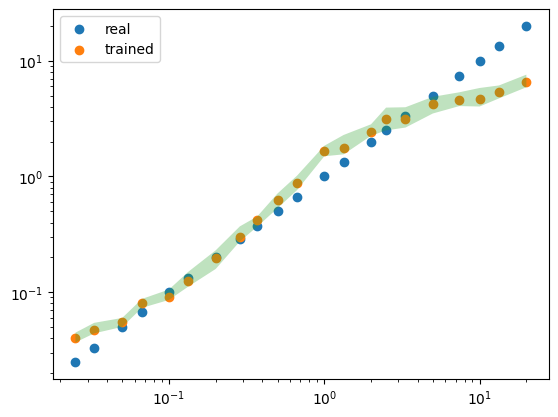

In [71]:
plt.scatter(rs,rs,label='real')
plt.scatter(rs,np.array(Bootstrap_mean),label='trained')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()
# plt.savefig('regression.png')

In [72]:
def test():
    model.eval()
    predictions = []
    total_loss = 0
    true_values = []
    with torch.no_grad():
        for data in testloader:
            data = data.to(device)
            output = model(data)
            loss = F.mse_loss(output, data.y)
            total_loss += loss.item() * data.num_graphs
            predictions.append(output.cpu())
            true_values.append(data.y.cpu())
    return torch.cat(predictions, dim=0), torch.cat(true_values, dim=0),total_loss / len(testloader.dataset)

In [73]:
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

In [74]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 0.4983


In [75]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [131]:
import pickle

# Assuming 'results' is your dictionary
with open('gnn_regression.pkl', 'wb') as file:
    pickle.dump(results, file)

In [58]:
rs[0,]

array([ 0.025,  0.033,  0.05 ,  0.067,  0.1  ,  0.133,  0.2  ,  0.286,
        0.5  ,  0.667,  1.   ,  1.333,  2.   ,  2.5  ,  3.333,  5.   ,
       10.   , 13.333, 20.   ])

In [76]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(21):
    r = rs[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

0.025
0.033
0.05
0.067
0.1
0.133
0.2
0.286
0.37
0.5
0.667
1.0
1.333
2.0
2.5
3.333
5.0
7.4
10.0
13.333
20.0


In [77]:
CI = np.array(Bootstrap_ci)

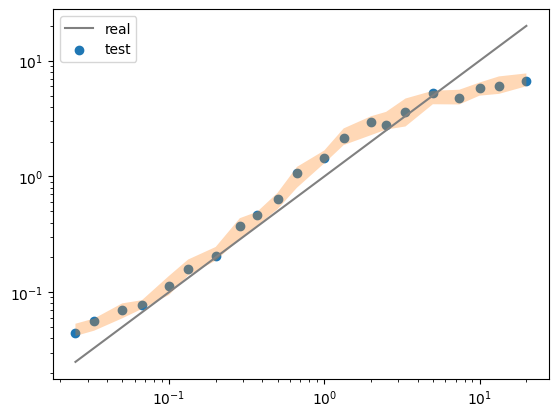

In [78]:
plt.plot(rs,rs,label='real',c='grey')
plt.scatter(rs,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

In [79]:
rs = rs[::-1]

50
58
59
59
54
61
64
71
59
56
65
56
53
63
63
59
48
64
60
69
69


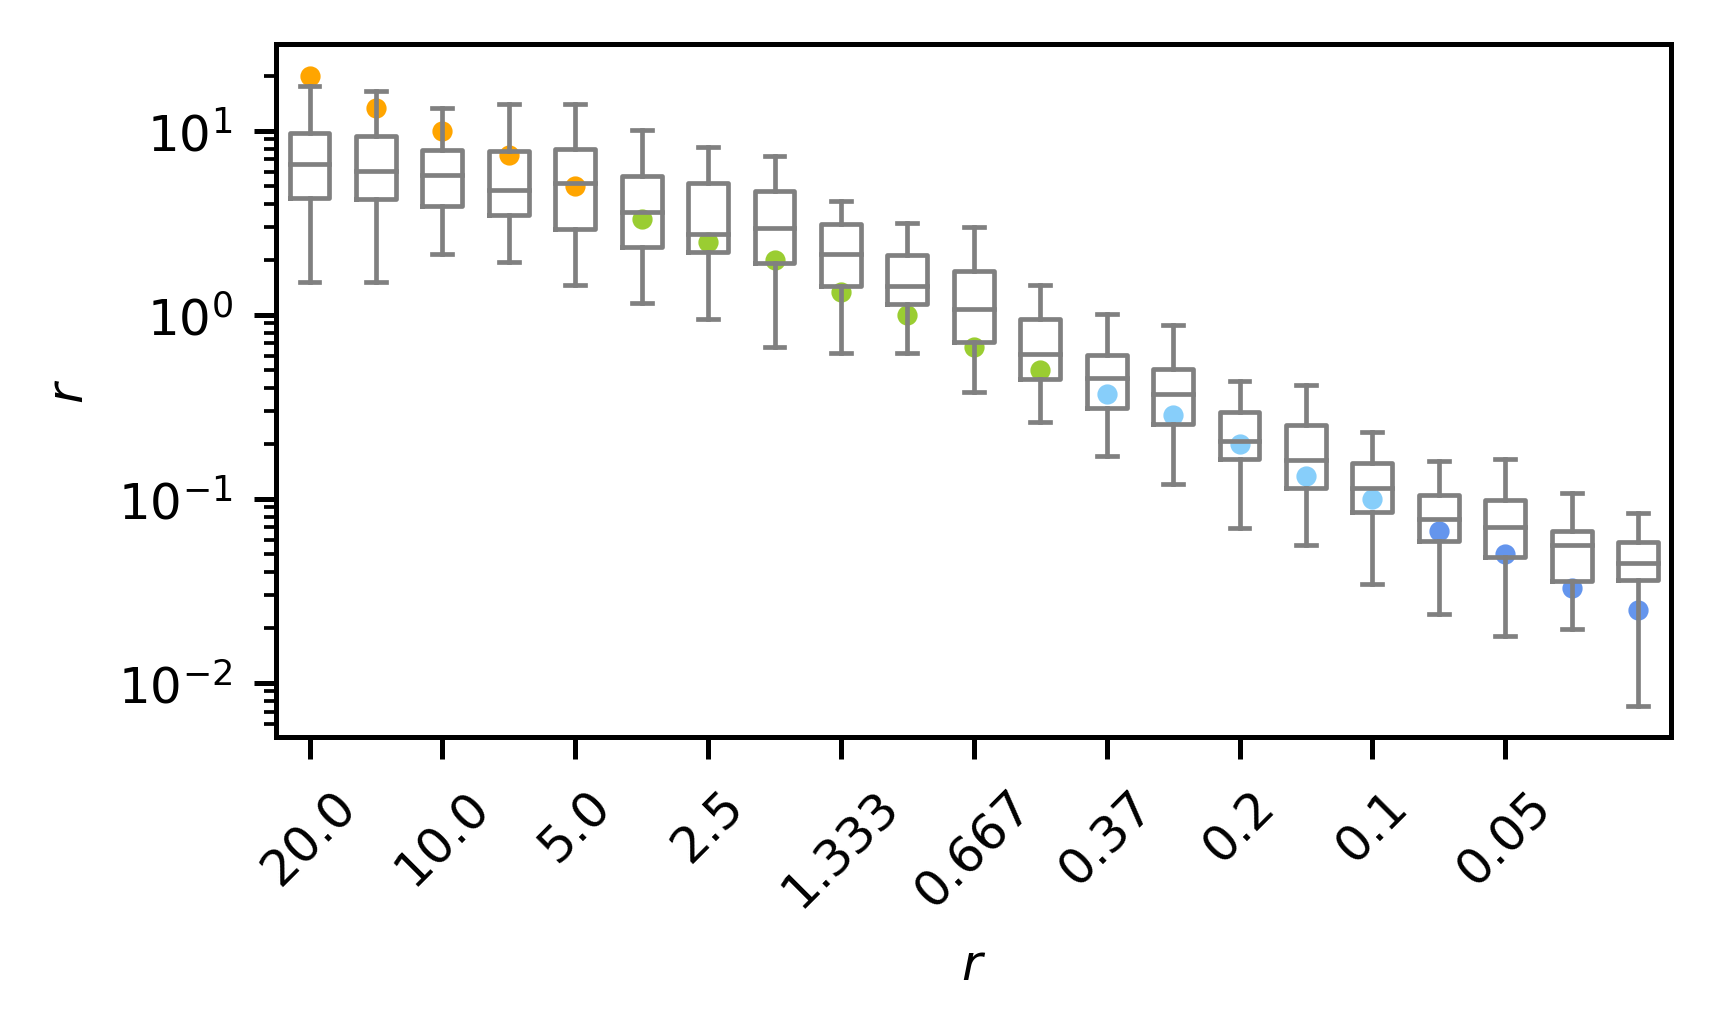

In [82]:
fig, ax = plt.subplots(figsize=(4,2.),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
#            5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
#         0.067:3,  0.033:3}
line_properties = dict(linestyle='-', linewidth=0.75, color='gray')


for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    real_pr = np.exp(results[r])
    std = np.std(real_pr)
    
    ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.6,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=0.75, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, r, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(np.array([0,2,4,6,8,10,12,14,16,18])+1)  # Setting x-ticks positions
ax.set_xticklabels(rs[[0,2,4,6,8,10,12,14,16,18]])  # Assuming 'rs' is your array of labels
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(-5,4)
plt.xticks(rotation=45)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

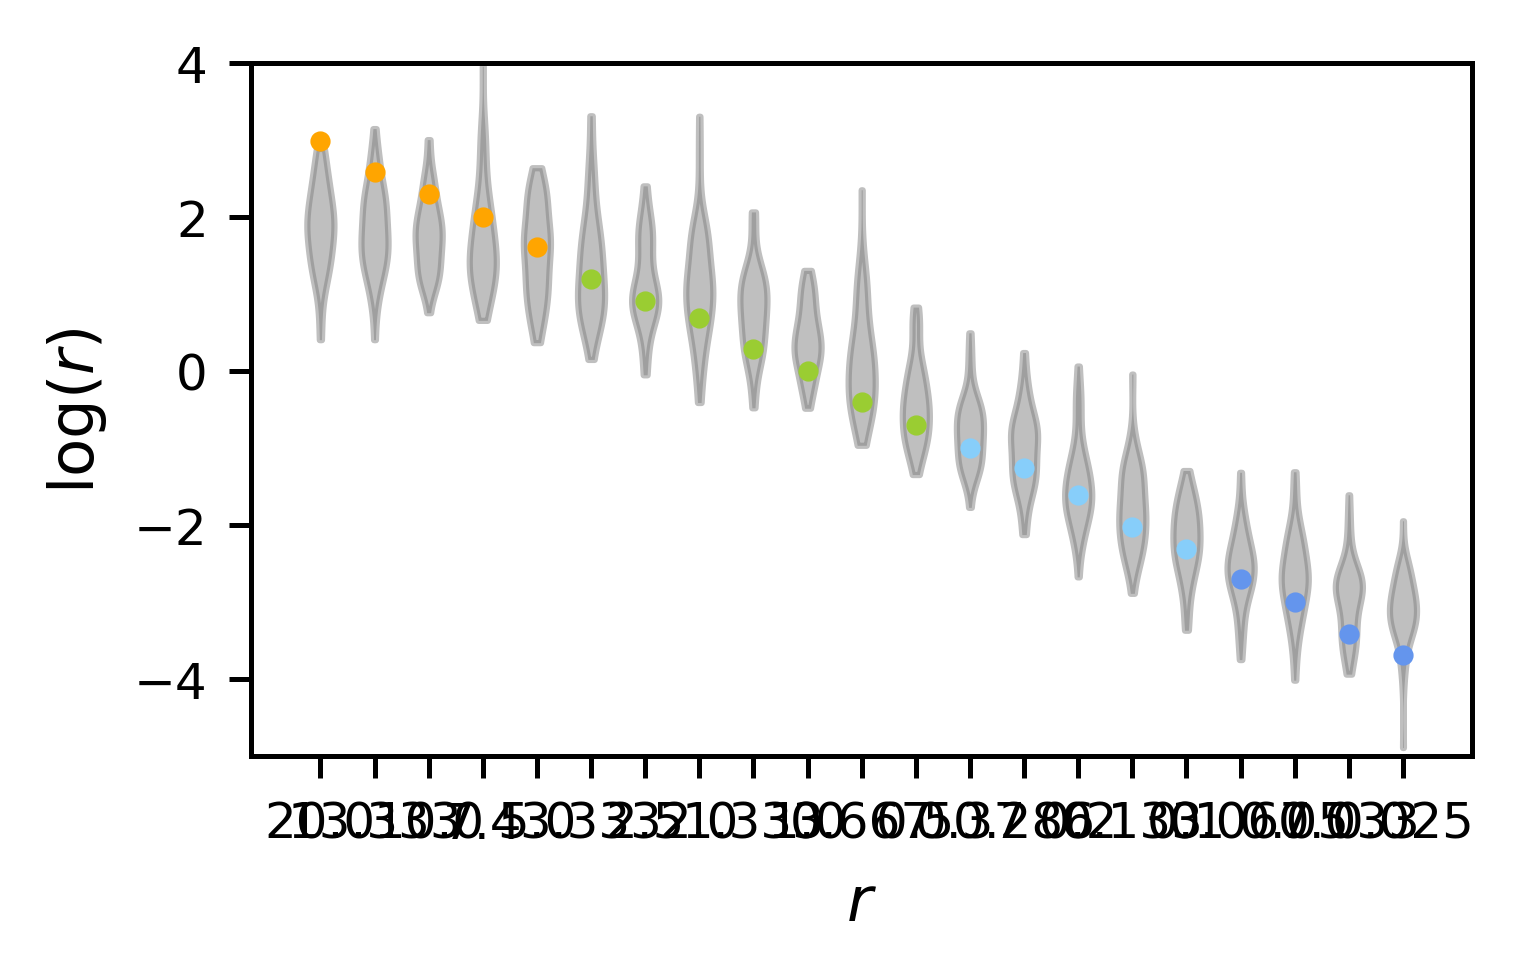

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'results' and 'rs' are defined as before

fig, ax = plt.subplots(figsize=(3.5,2), dpi=450)

colors = {0:'orange', 1:'yellowgreen', 2:'lightskyblue', 3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}

for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    
    # Creating the violin plot at position r_idx + 1
    vp = ax.violinplot(results[r], positions=[r_idx + 1], showmeans=False, showmedians=False, showextrema=False)
    
    # You can set the color of each part of the violin plot
    for pc in vp['bodies']:
        pc.set_facecolor('grey')
        pc.set_edgecolor('grey')
        pc.set_alpha(0.5)

    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, k, color=colors[c], s=5)

# Setting x-ticks positions and labels
ax.set_xticks(range(1, 22))
ax.set_xticklabels(rs)

# Setting the limits for y-axis and font size for ticks
plt.ylim(-5, 4)
plt.xlabel('$r$')
plt.ylabel('$\log(r)$')
ax.tick_params(axis='both', labelsize=8)

plt.show()


In [85]:
rs = rs[::-1]

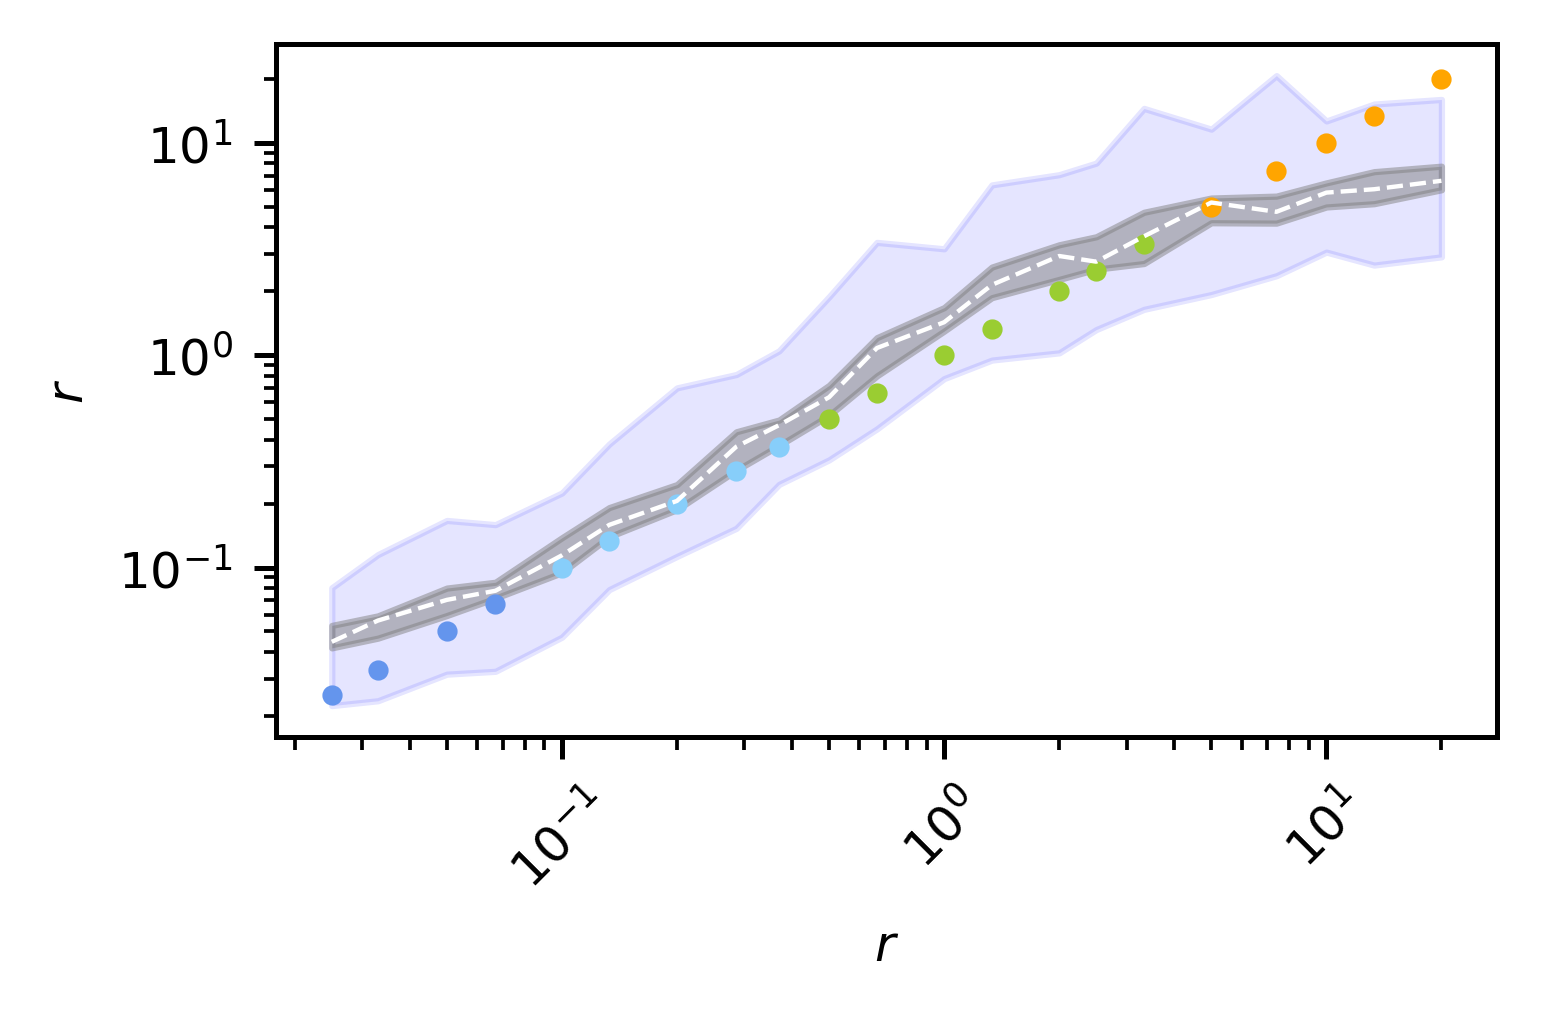

In [89]:
fig, ax = plt.subplots(figsize=(3.5,2),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
#            5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
#         0.067:3,  0.033:3}
line_properties = dict(linestyle='-', linewidth=0.75, color='gray')

# plt.plot(rs,rs,label='real',c='grey')
plt.plot(rs,np.array(Bootstrap_mean),ls='--',lw=0.7,color='white')

plt.fill_between(rs, np.array(per_5),np.array(per_95),
                 alpha=0.1,color='blue')
plt.fill_between(rs,CI[:,1],CI[:,0],alpha=0.5,color='grey')

for r_idx in range(21):
    r = rs[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
#     real_pr = np.exp(results[r])
#     std_list.append(np.std(real_pr))
#     median_list.append(np.median(real_pr))

    
#     ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
#                boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
#                whiskerprops=line_properties, widths=0.4,
#            capprops=line_properties,
#               medianprops=dict(linestyle='-', linewidth=1, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r, r, color=myc, s=5)

#     print(len(results[r]))
# plt.plot(rs, median_list,ls='--',lw=0.7)

# Show the plot after adding all boxplots
# label_pos = np.array([0,2,4,6,8,10,12,15,16,18])+1
# ax.set_xticks(label_pos)  # Setting x-ticks positions
# ax.set_xticklabels(rs[[0,2,4,6,8,10,12,15,16,18]])  # Assuming 'rs' is your array of labels
plt.xticks(rotation=45)
plt.yscale('log')
plt.xscale('log')
# plt.ylim(-5,4)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)
# plt.show()
# plt.savefig("gnn_regression.pdf", bbox_inches='tight', pad_inches=0)

In [90]:
rs_add = np.array([12.5 ,  4.  ,  0.4 ,  0.08])

In [91]:
export_dir = '/Users/qingyao/Documents/branching_data/simulation/unseen/'
#### data preparation
dataset = []
r_class = {12.5:0 ,  4.:1  ,  0.4:2 ,  0.08:3}
for r_idx in range(4):
    r = rs_add[r_idx]
    sub_export_dir = export_dir+'branching_R0-{}_r-{}/'.format(np.round(R0,2),np.round(r,3))
    r_c = r_class[r]
    print(r, r_c)
    # Create a list to hold our Data objects
    for g_idx in range(300):
        export_names = sub_export_dir+'NewInf_R0-{}_r-{}_{}.npy.gz'.format(np.round(R0,2),np.round(r,3),(g_idx+1))
        g_i = load_gzipped_numpy(export_names)
#         g_i_new = np.hstack((g_i[:,10:], prob_2d))
        g_i_new = g_i[:,10:]
        
        matrix = torch.from_numpy(g_i_new)
        
        y = torch.log(torch.tensor([[r]], dtype=torch.float))
#         y = torch.tensor([[r]], dtype=torch.float)
        # Create a Data object for each graph
        data = Data(x=matrix, edge_index=edge_index, edge_attr=edge_weights,y=y)
        data.x = data.x.float()
#         data.y = data.y.long()
        # Add the Data object to our list
        dataset.append(data)

12.5 0
4.0 1
0.4 2
0.08 3


In [92]:
testloader = DataLoader(dataset, batch_size=128, shuffle=True)

/Users/qingyao/anaconda3/envs/gnn/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [93]:
predictions, y_true, test_mse  = test()
print(f"Test MSE: {test_mse:.4f}")
# print(predictions)

Test MSE: 0.5267


In [94]:
results = {}
for p, t in zip(predictions.ravel().numpy(), y_true.ravel().numpy()):
    real_r = np.round(np.exp(t),3)
    if real_r in results.keys():
        results[real_r].append(p)
    else:
        results[real_r] = [p]

In [95]:
Bootstrap_ci = []
Bootstrap_mean = []
per_95 = []
per_5 = []
for r_idx in range(4):
    r = rs_add[r_idx]
    r = np.float32(r)
    print(r)
    data = np.exp(results[r])
#     data = training[r]
#     k = np.log(r)
#     print(len(data))
#     Bootstrap_mean.append(np.median(data))
    sample_median, l_b, u_b = bootstrap_median_confidence_interval(data,95,n_bootstraps=100)
    Bootstrap_ci.append([l_b, u_b])
    Bootstrap_mean.append(sample_median)
    per_95.append(np.percentile(data,95))
    per_5.append(np.percentile(data,5))

12.5
4.0
0.4
0.08


In [96]:
CI = np.array(Bootstrap_ci)

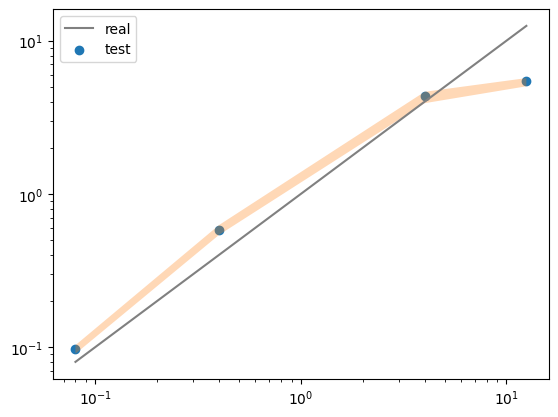

In [97]:
plt.plot(rs_add,rs_add,label='real',c='grey')
plt.scatter(rs_add,np.array(Bootstrap_mean),label='test')
plt.fill_between(rs_add,CI[:,1],CI[:,0],alpha=0.3)
plt.yscale('log')
plt.xscale('log')
plt.legend()

300
300
300
300


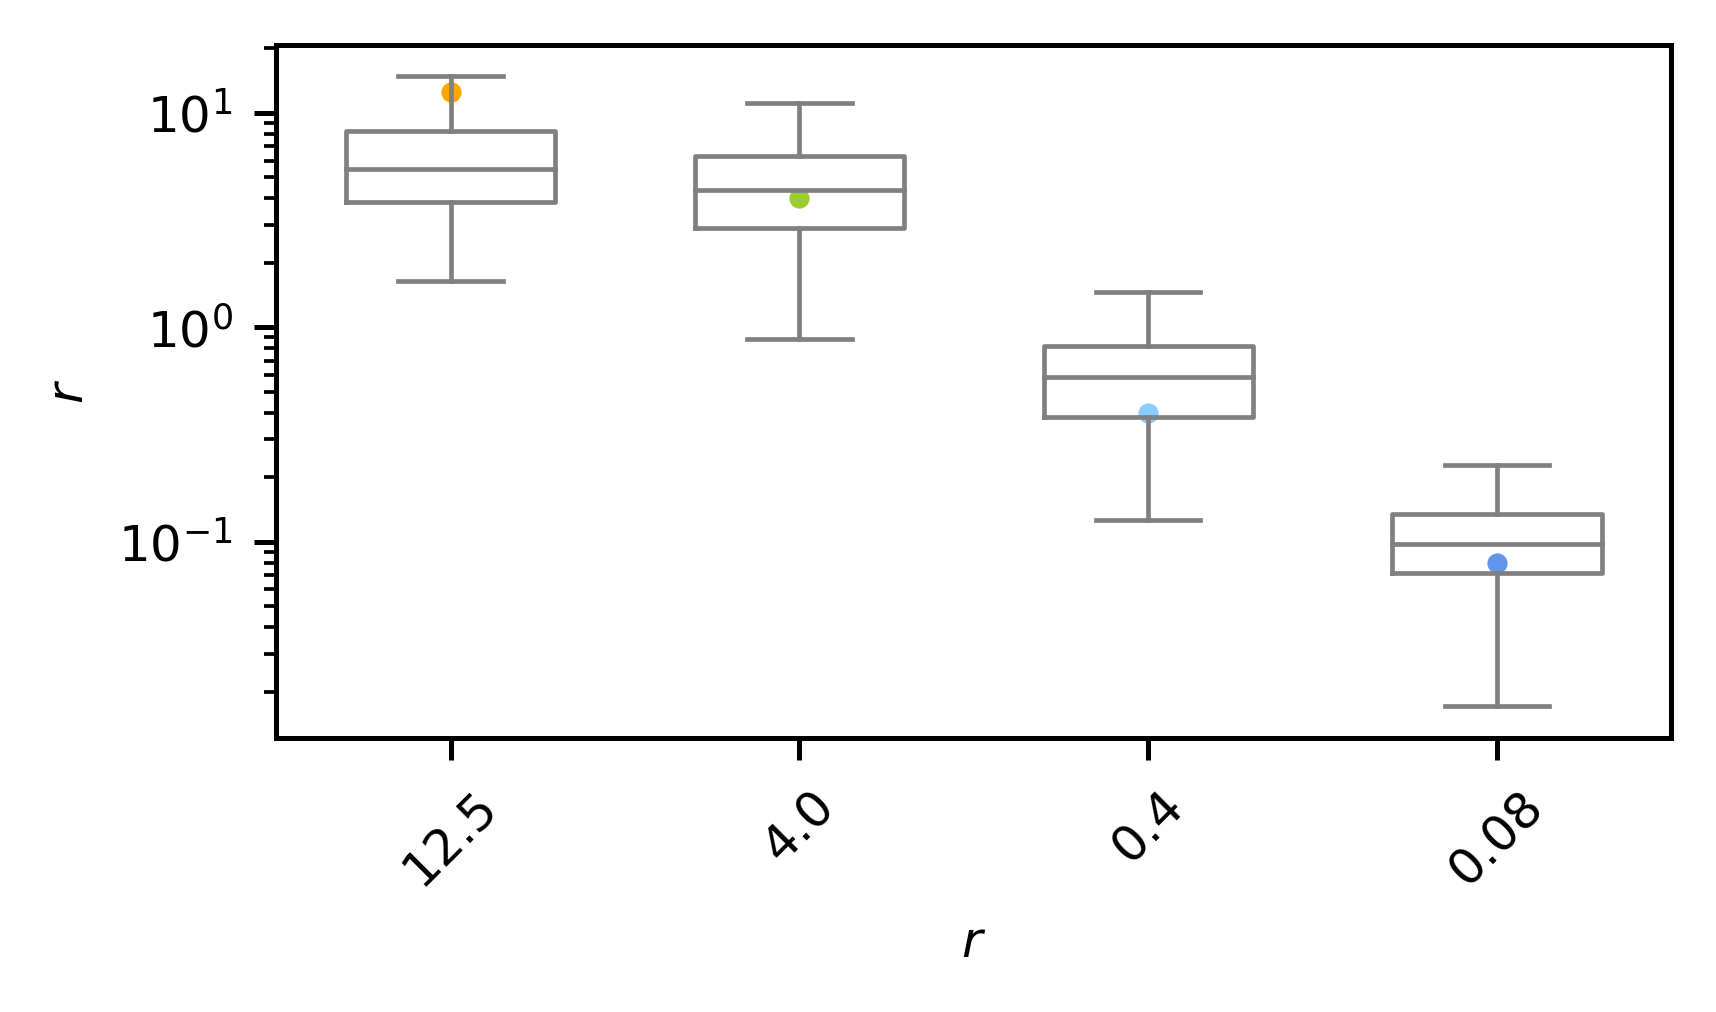

In [98]:
fig, ax = plt.subplots(figsize=(4,2.),dpi=450)
colors = {0:'orange',1:'yellowgreen',2:'lightskyblue',3:'cornflowerblue'}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3}
# r_class = {20:0, 10:0, 2.0:1, 1.0:1, 0.5:1, 0.2:2, 0.1:2, 0.05:3, 0.025:3, 
#            5.0:0 ,  2.5:1  , 13.333:0,  3.333:1,  1.333:1,  0.667:1,  0.286:2,  0.133:2,
#         0.067:3,  0.033:3}
line_properties = dict(linestyle='-', linewidth=0.75, color='gray')


for r_idx in range(4):
    r = rs_add[r_idx]
    k = np.log(r)
    c = r_class[r]
    r = np.float32(r)
    # Plot each boxplot at position k_idx + 1
#     y = np.exp()
#     ax.boxplot(results[k], positions=[k_idx + 1])
    real_pr = np.exp(results[r])
    std = np.std(real_pr)
    
    ax.boxplot(real_pr, positions=[r_idx+1],showfliers=False,
               boxprops = dict(linestyle='-', linewidth=0.75, color='gray'),
               whiskerprops=line_properties, widths=0.6,
           capprops=line_properties,
              medianprops=dict(linestyle='-', linewidth=0.75, color='gray'))
    
    myc = colors[c]
    # Plot the scatter point at the same position
    ax.scatter(r_idx + 1, r, color=myc, s=5)

    print(len(results[r]))

# Show the plot after adding all boxplots
ax.set_xticks(np.array([0,1,2,3])+1)  # Setting x-ticks positions
ax.set_xticklabels(rs_add)  # Assuming 'rs' is your array of labels
plt.yscale('log')
# plt.xscale('log')
# plt.ylim(-5,4)
plt.xticks(rotation=45)
plt.xlabel('$r$',size=8)
plt.ylabel('$r$',size=8)
ax.tick_params(axis='both', labelsize=8)